In [1]:
from statsbomb_data_extraction import Game, fetch_matches_for_season, fetch_all_seasons_for_league
from statsbomb_event_parsing import get_events_for_game, plot_event
from draw_pitch import draw_pitch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms.traversal.depth_first_search import dfs_edges
from networkx.algorithms.dag import dag_longest_path

In [2]:
season_11_12 = fetch_matches_for_season("https://github.com/statsbomb/open-data/blob/master/data/matches/11/22.json")

In [3]:
events_df = get_events_for_game(season_11_12["69236"].json_file)
events_df

,eventname,x,y,xend,yend,statsbombxg,related events
ids,,,,,,,
f78d965c-131a-45c1-b2ac-4a059a349a83,pass,61.0,41.0,61.4,43.0,-1.0,[bb571e25-05a1-473c-82ca-e7d3f5bba3db]
bb571e25-05a1-473c-82ca-e7d3f5bba3db,ball receipt*,61.4,43.0,-1.0,-1.0,-1.0,[f78d965c-131a-45c1-b2ac-4a059a349a83]
0e1a1ed3-6295-40d4-b367-cc94b5163be5,pass,61.8,43.9,49.9,51.2,-1.0,[cdcc83d5-12a9-4f9d-8a35-5b00bf811491]
cdcc83d5-12a9-4f9d-8a35-5b00bf811491,ball receipt*,49.9,51.2,-1.0,-1.0,-1.0,[0e1a1ed3-6295-40d4-b367-cc94b5163be5]
bed73e6e-222a-4c8a-acf4-acbc896d1669,carry,49.9,51.2,50.1,57.5,-1.0,"[1b8c0035-9d32-4483-b34e-5824b414e601, 5773bd7..."
...,...,...,...,...,...,...,...
a902153e-8a9f-464a-a7b1-818e6ca39df8,pass,108.6,75.2,108.2,73.0,-1.0,[5858d320-baa5-4bed-915e-5bdac82b7c35]
30a4eff0-a1cc-44f3-9549-a90177090c92,pass,98.6,80.0,106.0,68.6,-1.0,[e9da71f9-d47d-47bb-b14b-c07f140f9576]
e9da71f9-d47d-47bb-b14b-c07f140f9576,ball receipt*,106.0,68.6,-1.0,-1.0,-1.0,[30a4eff0-a1cc-44f3-9549-a90177090c92]


In [4]:
events_graph = nx.Graph()
events_graph.add_nodes_from(events_df.index)

for rows, cols in events_df.iterrows():
    if cols["related events"] != []:
        events_graph.add_edges_from([(rows, x) for x in cols["related events"] if x in events_df.index])

In [5]:
def largest_distance(my_graph):
    """
    Function which takes a graph and returns a tuple containing:
    1. the maximum degree of separation between any two vertices
    2. a set of all pairs of vertices whose separation is maximum
    
    Arguments:
    ----------
    my_graph (nx.Graph object) 
        - graph for which we want to find the pairs of nodes which have the highest degree of separation
    
    Returns:
    --------
    (tuple) 
        - maximum degree of separation, set of pairs of vertices whose separation is maximum
    """
    assert str(type(my_graph)) == "<class 'networkx.classes.graph.Graph'>"
    
    #keep track of highest degree of separation
    largest_nodes_set = set()
    largest_distance = 0

    for node, dict_of_distances in nx.shortest_path_length(my_graph):
        
        #keep track of highest degree of separation for current node
        max_node_distance = 0
        furthest_nodes_from_node = set()
        
        #check degree of separation with other nodes, form new set if greater than current max degree of separation
        for other_node, distance in dict_of_distances.items():
            
            if distance > max_node_distance:
                max_node_distance = distance
                new_pair = tuple(sorted((node, other_node)))
                furthest_nodes_from_node = {new_pair}
            
            #add pair of notes to set if equal to current max degree
            elif distance == max_node_distance and distance:
                new_pair = tuple(sorted((node, other_node)))
                furthest_nodes_from_node.add(new_pair)
        
        #check if max degree of seperation for this node is greater than overall max degree of separation
        #form new set if greater than current max degree of separation
        if max_node_distance > largest_distance:
            largest_distance = max_node_distance
            largest_nodes_set = furthest_nodes_from_node
        #add pairs of nodes to set if equal to current max degree of separation
        elif max_node_distance == largest_distance:
            largest_nodes_set = largest_nodes_set | furthest_nodes_from_node

    return largest_distance, largest_nodes_set

def get_sequences(event_graph):
    """
    
    """
    sequences = []
    for connected_comp in list(nx.connected_components(events_graph)):
        graph = events_graph.subgraph(connected_comp)
        nodes = largest_distance(graph)
        if nodes[0] != 0:
            path = nx.shortest_path(graph,
                                    source=list(nodes[1])[0][0], 
                                    target=list(nodes[1])[0][1])

            sequences.append(path)
    
    return sequences

In [6]:
all_sequences = get_sequences(events_graph);

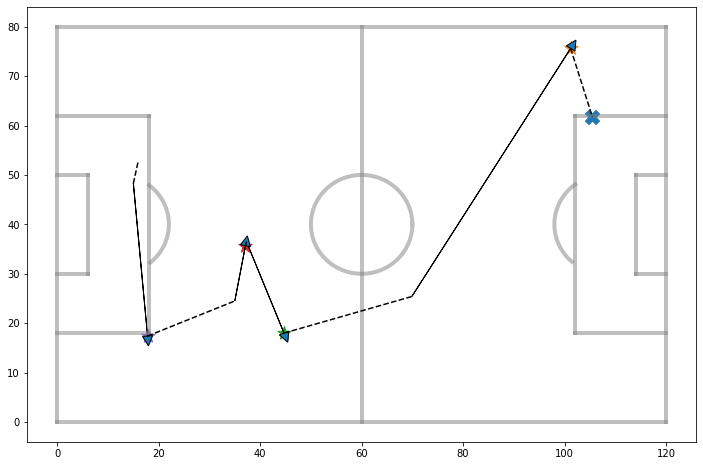

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(120/10, 80/10))
draw_pitch(axis=ax, rotate=True)
for sequence in all_sequences[2:3]:
    for event in sequence:
        plot_event(events_df=events_df, eventid=event, axis=ax)